In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from openslide import OpenSlide
from PIL import Image
from collections import defaultdict

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mayo-clinic-strip-ai/sample_submission.csv
/kaggle/input/mayo-clinic-strip-ai/train.csv
/kaggle/input/mayo-clinic-strip-ai/test.csv
/kaggle/input/mayo-clinic-strip-ai/other.csv
/kaggle/input/mayo-clinic-strip-ai/other/314263_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/0b33d7_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/54334d_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/84c279_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/cca9eb_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/880188_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/2e3078_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/9daa03_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/065053_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/8acdfa_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/91530f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/a2253f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/f5eb8f_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/ab830f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/d17ad3_2.tif

# Metadata

In [2]:
train = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
other = pd.read_csv('../input/mayo-clinic-strip-ai/other.csv')

In [3]:
train.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [9]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
train[0:50]

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE
5,028989_0,5,028989,0,LAA
6,029c68_0,5,029c68,0,CE
7,032f10_0,7,032f10,0,CE
8,0372b0_0,7,0372b0,0,CE
9,037300_0,11,037300,0,CE


In [6]:
train.isnull().sum()

image_id      0
center_id     0
patient_id    0
image_num     0
label         0
dtype: int64

In [7]:
test.head()

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


In [10]:
test.isnull().sum()

image_id      0
center_id     0
patient_id    0
image_num     0
dtype: int64

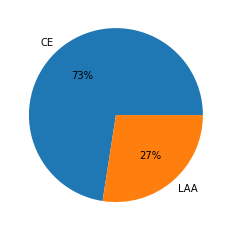

In [15]:
# imbalanced data
x = train.label.value_counts()
labels = np.array(x.index)
sizes = np.array((x/x.sum())*100)
plt.pie(sizes, labels = labels, autopct='%.0f%%')
plt.show()

In [19]:
# all images to each patient have the same label
different = train.groupby('patient_id').filter(lambda x: x['label'].nunique()>1 ).sort_values('patient_id')
different

,image_id,center_id,patient_id,image_num,label


In [32]:
# each patient belongs to a single center
different = train.groupby('patient_id').filter(lambda x: x['center_id'].nunique()>1 ).sort_values('patient_id')
different

,image_id,center_id,patient_id,image_num,label


In [31]:
train['patient_id'].nunique()

632

# Images

Reference: https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration

In [3]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


In [4]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


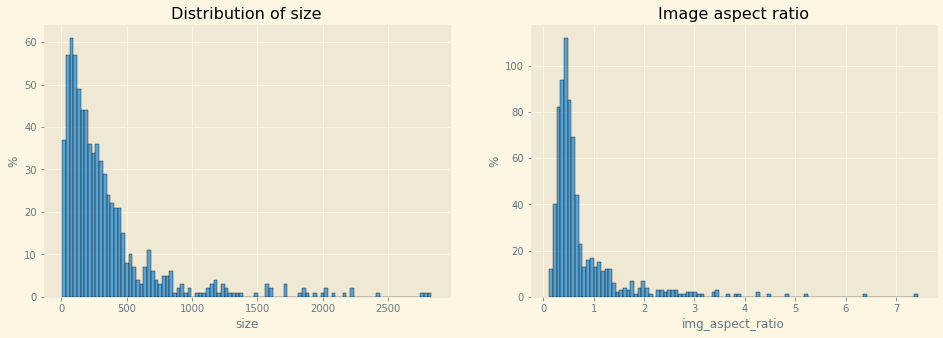

In [5]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

In [6]:
Image.MAX_IMAGE_PIXELS = None
CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']

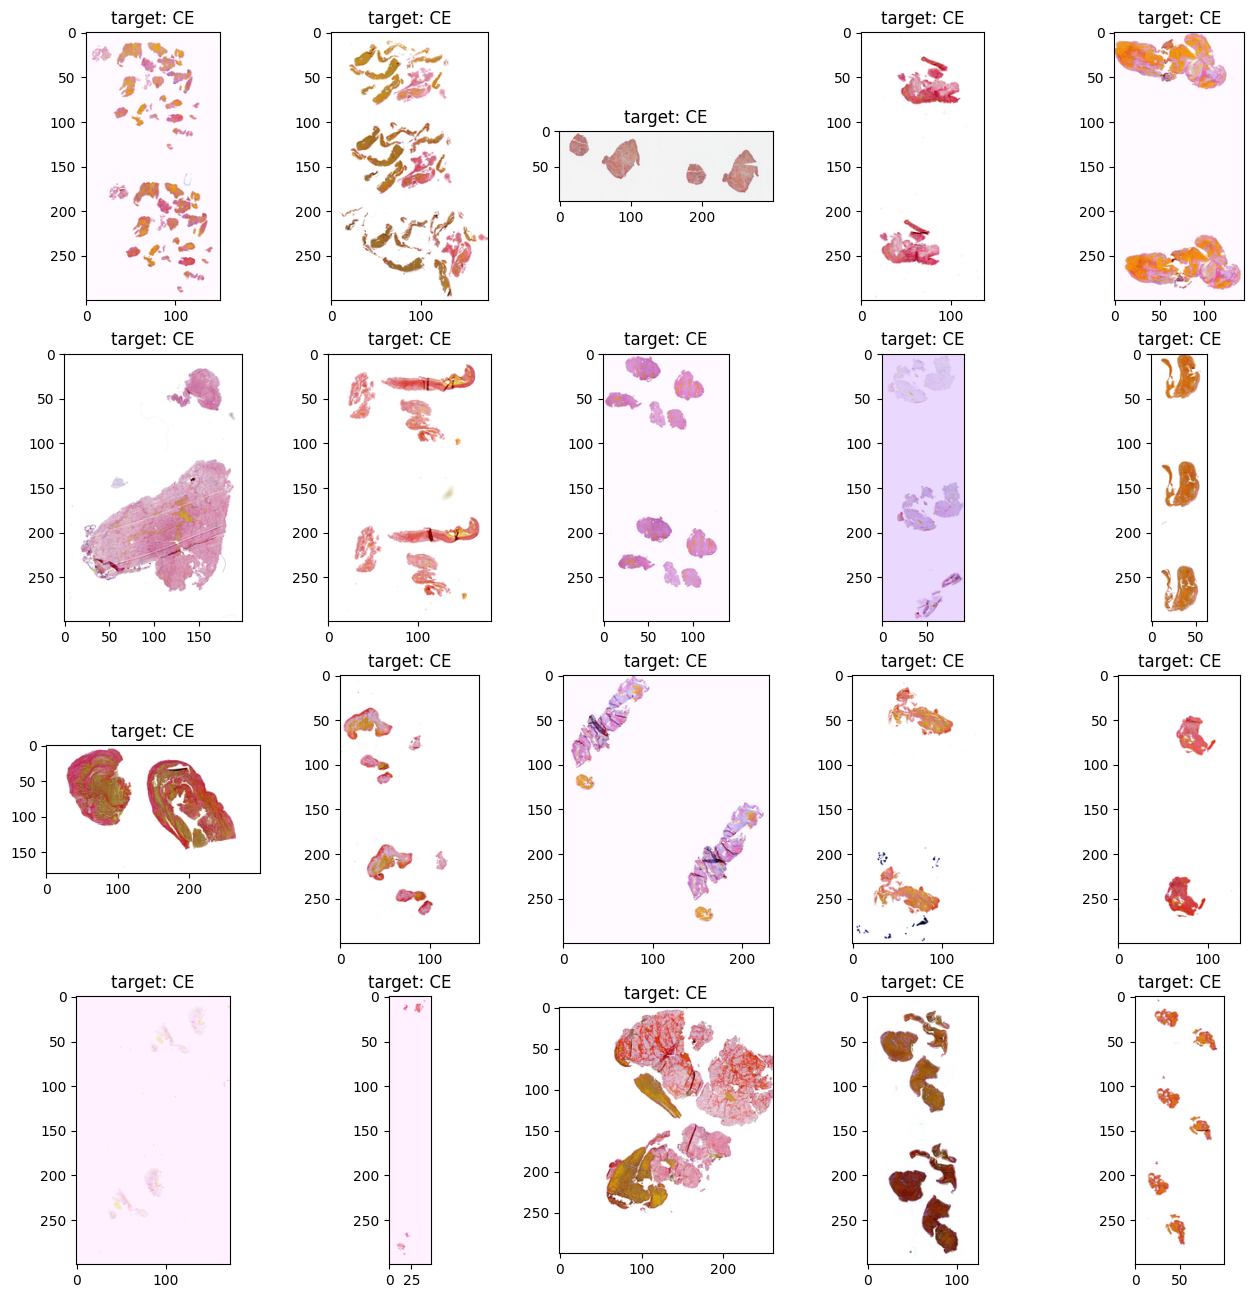

In [8]:
plt.style.use('default')
fig, axes = plt.subplots(4,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

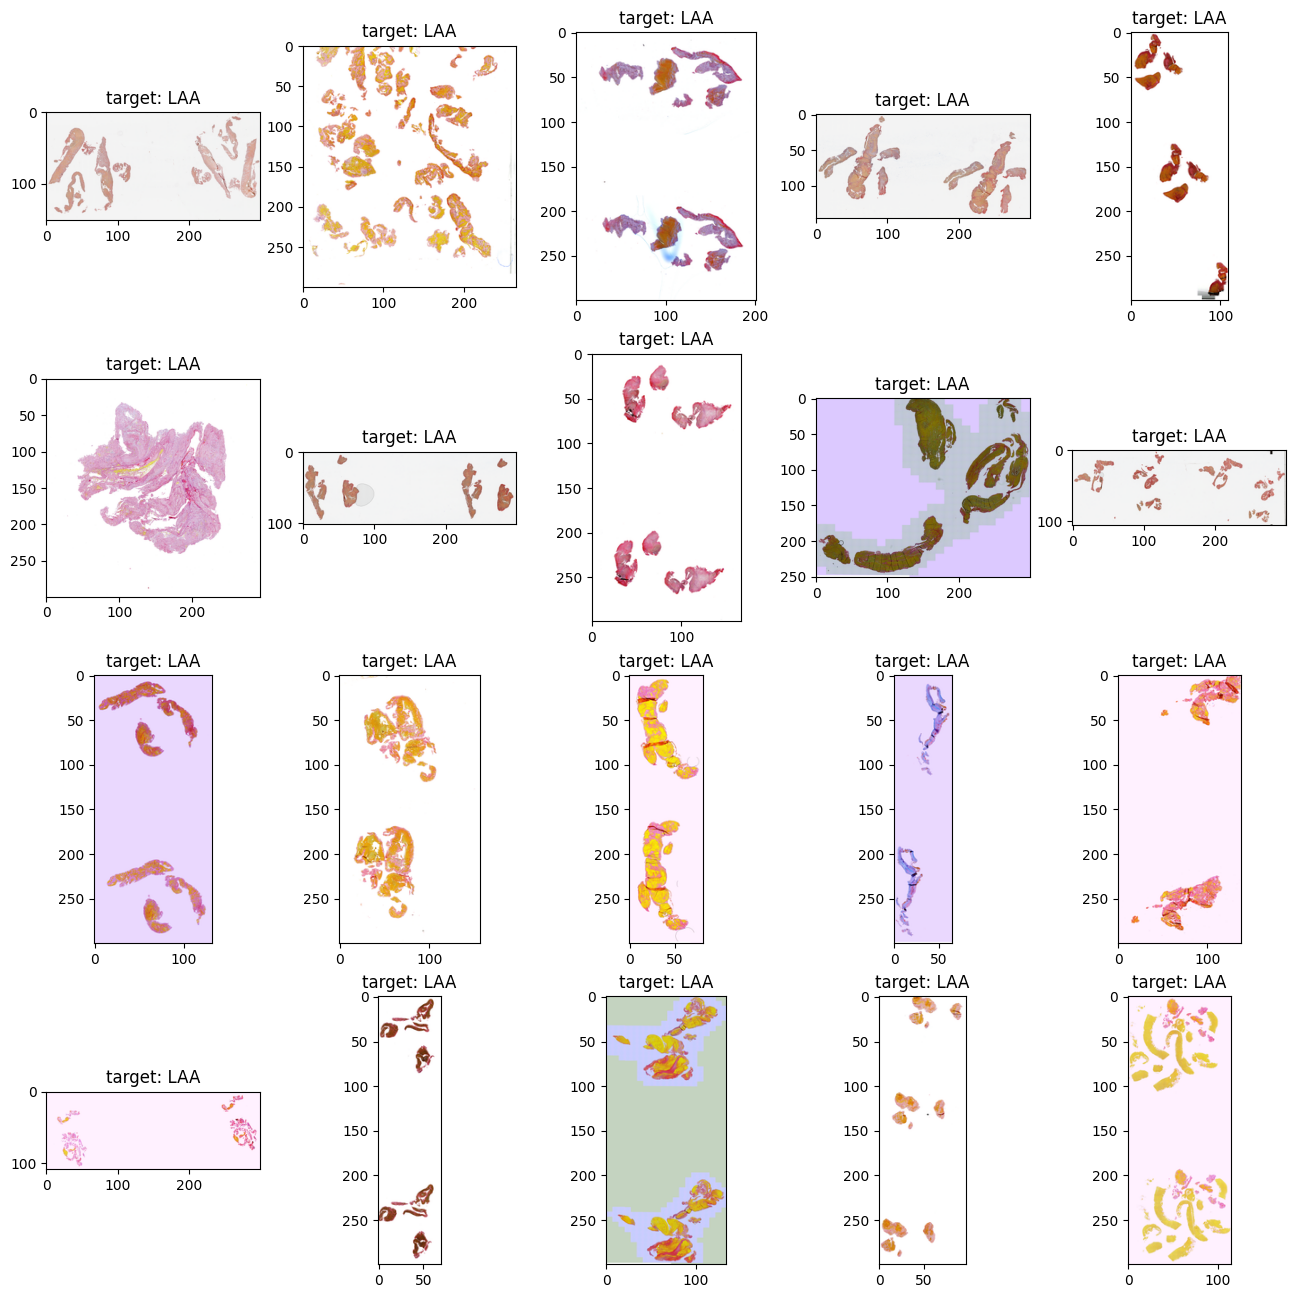

In [9]:
fig, axes = plt.subplots(4,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()